<a href="https://colab.research.google.com/github/YonghwanYim/user-embed-former/blob/main/segment_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# User Embedding and Classification with Transformer

In [ ]:
# Load libraries
import pandas as pd
import numpy as np
import random

# Analysis
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Toy model data generation
Randomly generated data.
Clusters are not separable (for experimental purposes only)

In [ ]:
# Generate user logs
num_users = 2000
min_actions = 5
max_actions = 20

actions = [
    'move_map', 'start_quest', 'complete_quest',
    'buy_cash_item', 'use_item', 'sell_on_auction', 'trade_in_exchange',
    'chat', 'join_party', 'leave_party'
]

# Create new user logs
user_logs = []

for i in range(num_users):
    user_id = f"user_{i+1:04d}"
    n_actions = random.randint(min_actions, max_actions)

    # Always start with 'login' and end with 'logout'
    core_actions = random.choices(actions, k=n_actions - 2)
    action_seq = ['login'] + core_actions + ['logout']

    # Generate timestamps for each action
    start_time = pd.Timestamp("2025-01-01") + pd.to_timedelta(random.randint(0, 60*24*30), unit="m")
    timestamps = [start_time + pd.Timedelta(minutes=idx * random.randint(1, 5)) for idx in range(n_actions)]

    user_logs.extend(list(zip([user_id]*n_actions, timestamps, action_seq)))

# Create and sort the DataFrame
df_seq_conditional = pd.DataFrame(user_logs, columns=["user_id", "timestamp", "action"])
df_seq_conditional = df_seq_conditional.sort_values(["user_id", "timestamp"]).reset_index(drop=True)

In [ ]:
print(df_seq_conditional.head(20)) # Preview the generated user log data

      user_id           timestamp             action
0   user_0001 2025-01-30 02:44:00              login
1   user_0001 2025-01-30 02:47:00      buy_cash_item
2   user_0001 2025-01-30 02:48:00        leave_party
3   user_0001 2025-01-30 02:48:00         join_party
4   user_0001 2025-01-30 02:53:00      buy_cash_item
5   user_0001 2025-01-30 02:59:00             logout
6   user_0002 2025-01-04 18:16:00              login
7   user_0002 2025-01-04 18:20:00         join_party
8   user_0002 2025-01-04 18:22:00               chat
9   user_0002 2025-01-04 18:26:00      buy_cash_item
10  user_0002 2025-01-04 18:28:00    sell_on_auction
11  user_0002 2025-01-04 18:32:00        leave_party
12  user_0002 2025-01-04 18:40:00         join_party
13  user_0002 2025-01-04 18:40:00    sell_on_auction
14  user_0002 2025-01-04 18:40:00             logout
15  user_0002 2025-01-04 18:43:00  trade_in_exchange
16  user_0002 2025-01-04 18:51:00      buy_cash_item
17  user_0002 2025-01-04 18:56:00           us

# Tokenization and preprocessing

In [ ]:
# Map actions to tokens
action_vocab = {action: idx + 1 for idx, action in enumerate(df_seq_conditional['action'].unique())}
action_vocab['[PAD]'] = 0  # padding token

# Convert user action sequences to tokenized sequences
df_seq_conditional = df_seq_conditional.sort_values(['user_id', 'timestamp'])
user_sequences = df_seq_conditional.groupby('user_id')['action'].apply(list)
tokenized_sequences = [torch.tensor([action_vocab[a] for a in seq], dtype=torch.long) for seq in user_sequences]

# Pad sequences to the same length
padded_seqs = pad_sequence(tokenized_sequences, batch_first=True, padding_value=0)
attention_mask = (padded_seqs != 0).long() # Mask out padding tokens

# Define Transformer embedding model


In [ ]:
class UserTransformer(nn.Module):
    """
    Use the output of the Transformer encoder as the embedding; decoder is not implemented
    """
    def __init__(self, vocab_size, d_model=64, nhead=4, num_layers=2):  #
        super().__init__()
        # Embedding layer to convert token indices to dense vectors
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=0)

        # Define a single Transformer encoder layer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            batch_first=True)  # Enables (batch, seq, feature) input shape

        # Stack multiple encoder layers
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x, mask):
        # x: (batch_size, seq_len), token indices
        # mask: (batch_size, seq_len), 1 for valid tokens, 0 for padding
        x = self.embedding(x)
        x = self.encoder(x, src_key_padding_mask=~mask.bool())
        x_masked_avg = (x * mask.unsqueeze(-1)).sum(1) / mask.sum(1, keepdim=True)  # masked average pooling
        return x_masked_avg

# Model initialization and embedding extraction

In [ ]:
vocab_size = len(action_vocab)
model = UserTransformer(vocab_size)

with torch.no_grad():
    user_embeddings = model(padded_seqs, attention_mask)  # shape: (num_users, d_model

In [ ]:
print("Shape:", user_embeddings.shape)
print("First user embedding:\n", user_embeddings[0])

Shape: torch.Size([2000, 64])
First user embedding:
 tensor([ 0.7401,  0.0898,  0.4490, -0.9012,  0.2741,  0.5184,  0.4329,  0.2883,
         0.5239,  0.1412,  0.2500, -0.4689, -0.1143,  0.0113, -0.8218, -0.0765,
         0.5542,  0.8248,  0.3386, -0.3135, -0.5056, -0.5572, -0.2576, -0.6571,
         0.4464, -0.6456, -0.6985,  0.2469,  0.6680, -0.7288, -0.0174,  0.1993,
        -0.2013, -0.4878,  0.5445, -0.7158,  0.0966, -0.2542,  0.1204,  1.2927,
        -0.7632,  0.2133,  0.0070, -0.4683,  0.2854, -0.3140, -1.0235,  0.3121,
        -0.0384, -0.3042,  0.5762, -0.2253,  0.4147, -0.1980,  0.8671, -0.3419,
         0.7502, -0.0769,  0.1351, -0.0386,  0.3124, -0.3217, -0.4257,  0.0379])


# Clustering and visualization using PCA

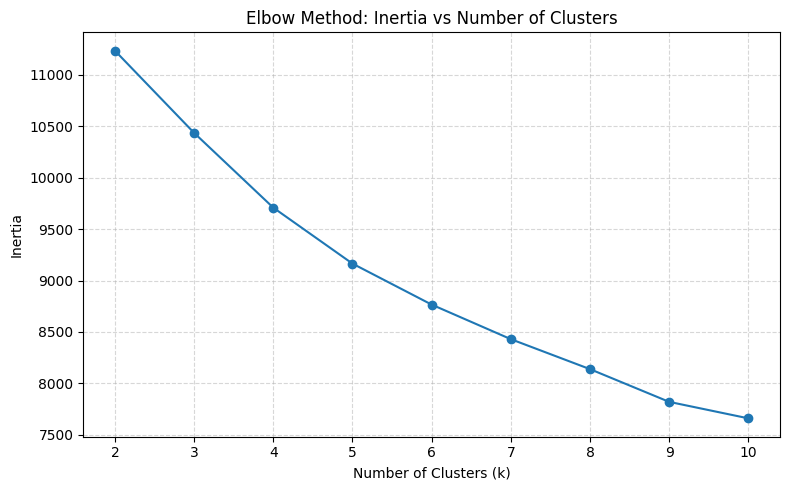

In [ ]:
# Elbow method (to determine the optimal number of clusters))
inertias = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(user_embeddings.numpy())
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), inertias, marker='o')
plt.title("Elbow Method: Inertia vs Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

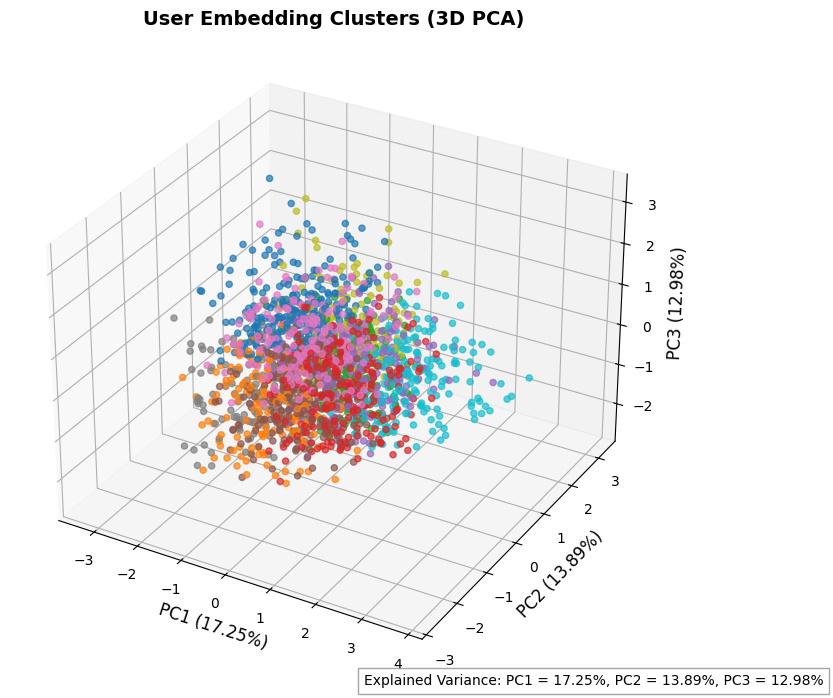

In [ ]:
# K-Means clustering
kmeans = KMeans(n_clusters=10, random_state=42)
cluster_labels = kmeans.fit_predict(user_embeddings.numpy())

# PCA for 3D visualization (Even with 3 components, explained variance is below 50% ...)
pca_3d = PCA(n_components=3)
reduced_3d = pca_3d.fit_transform(user_embeddings.numpy())
explained_3d = pca_3d.explained_variance_ratio_
explained_text_3d = f"Explained Variance: PC1 = {explained_3d[0]:.2%}, PC2 = {explained_3d[1]:.2%}, PC3 = {explained_3d[2]:.2%}"


# Cluster visualization
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(reduced_3d[:, 0], reduced_3d[:, 1], reduced_3d[:, 2],
                     c=cluster_labels, cmap='tab10', alpha=0.7)

ax.set_title("User Embedding Clusters (3D PCA)", fontsize=14, fontweight='bold')
ax.set_xlabel(f"PC1 ({explained_3d[0]:.2%})", fontsize=12)
ax.set_ylabel(f"PC2 ({explained_3d[1]:.2%})", fontsize=12)
ax.set_zlabel(f"PC3 ({explained_3d[2]:.2%})", fontsize=12)

plt.figtext(0.99, 0.01, explained_text_3d, fontsize=10, ha='right', va='bottom',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))

plt.tight_layout()
plt.show()

In [ ]:
# The silhouette score is low, indicating that the clusters are not well separated.
from sklearn.metrics import silhouette_score

score = silhouette_score(user_embeddings.numpy(), cluster_labels)
print(f"Silhouette Score: {score:.4f}")

Silhouette Score: 0.0880


UMAP (nonlinear dimensionality reduction)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


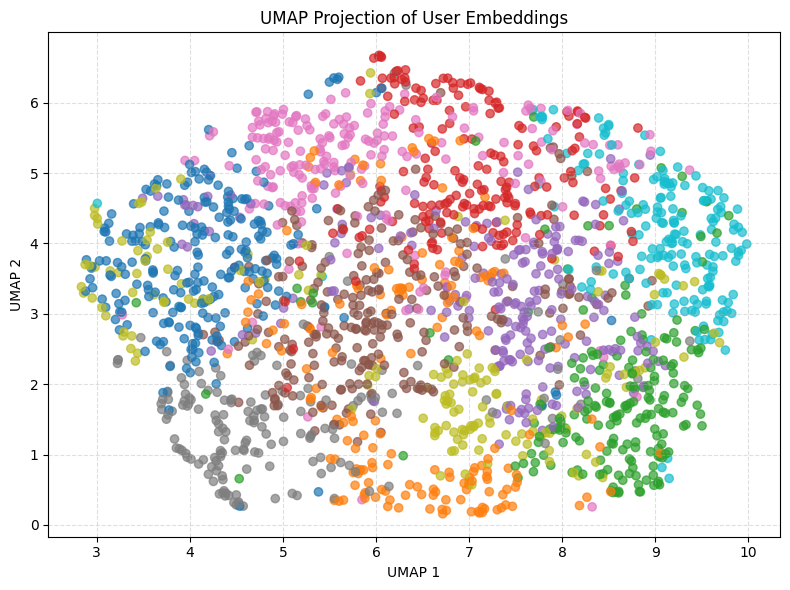

In [ ]:
from umap import UMAP

umap = UMAP(n_components=2, random_state=42)
umap_2d = umap.fit_transform(user_embeddings.numpy())

plt.figure(figsize=(8, 6))
plt.scatter(umap_2d[:, 0], umap_2d[:, 1], c=cluster_labels, cmap='tab10', alpha=0.7)
plt.title("UMAP Projection of User Embeddings")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# Since the clusters are not meaningful, cluster interpretation is excluded.